In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import traceback

Helper functions for handling the interpolation of the ground truth

In [2]:
class Trace(object):
    def __init__(self, params):
        self.times = []
        self.params = {}
        for p in params:
            self.params[p] = []
    def frame(self, t, **params):
        self.times.append(t)
        for p in self.params.keys():
            if p not in params:
                self.params[p].append(self.params[p][-1])
            else:
                self.params[p].append(params[p])

    def get(self, t, p):
        if t < self.times[0]:
            return None
        elif t > self.times[-1]:
            return None
        else:
            return np.interp([t], self.times, self.params[p])[0]


def load_trace(fn):
    if not os.path.isfile(fn):
        return None
    else:
        with open(fn) as f:
            code = f.read()
        locals = dict()
        globals = dict(Trace=Trace)
        try:
            exec(code, globals, locals)
        except:
            traceback.print_exc()
            return None
        for k, v in locals.items():
            if isinstance(v, Trace):
                return v
        else:
            return None


Load in a data file and turn it into a big list of images and ground truth data

In [114]:
def extract_targets(filename, dt, t_start=None, t_end=None):
    trace = load_trace(filename+'.label')
    if t_end is None:        
        t_end = trace.times[-1] if trace is not None and len(trace.times)>0 else -1
    if t_start is None:
        t_start = 0
        
    times = []
    targets = []
    now = t_start
    while now < t_end:
        xx = trace.get(now, 'x')
        yy = trace.get(now, 'y')
        rr = trace.get(now, 'r')
        valid = 1 if xx is not None else 0
        if xx is None:
            xx = -1
        if yy is None:
            yy = -1
        if rr is None:
            rr = -1

        now += dt

        targets.append([xx, yy, rr, valid])
        times.append(now)

    targets = np.array(targets).reshape(-1, 4)
    times = np.array(times)
    
    return times, targets
        
    

In [115]:
def extract_images(filename,        # filename to load data from 
                   dt,              # time between images to create (seconds)
                   decay_time=0.1,  # spike decay time (seconds)
                   t_start=None,    # time to start generating images (seconds)
                   t_end=None       # time to end generating images (seconds)
                  ):
    packet_size = 8

    with open(filename, 'rb') as f:
        data = f.read()
    data = np.fromstring(data, np.uint8)

    # find x and y values for events
    y = ((data[1::packet_size].astype('uint16')<<8) + data[::packet_size]) >> 2
    x = ((data[3::packet_size].astype('uint16')<<8) + data[2::packet_size]) >> 1
    # get the polarity (+1 for on events, -1 for off events)
    p = np.where((data[::packet_size] & 0x02) == 0x02, 1, -1)
    v = np.where((data[::packet_size] & 0x01) == 0x01, 1, -1)
    # find the time stamp for each event, in seconds from the start of the file
    t = data[7::packet_size].astype(np.uint32)
    t = (t << 8) + data[6::packet_size]
    t = (t << 8) + data[5::packet_size]
    t = (t << 8) + data[4::packet_size]
    #t = t - t[0]
    t = t.astype(float) / 1000000   # convert microseconds to seconds

    if t_start is None:
        t_start = 0
    if t_end is None:
        t_end = t[-1]

    image = np.zeros((180, 240), dtype=float)

    images = []
    targets = []
    times = []

    event_index = 0   # for keeping track of where we are in the file
    if t_start > 0:
        event_index = np.searchsorted(t, t_start)

    now = t_start

    event_dt = dt

    while now < t_end:
        if event_dt != 0:
            decay_scale = 1-np.abs(event_dt)/(np.abs(event_dt)+decay_time)
            image *= decay_scale

        if event_dt > 0:
            count = np.searchsorted(t[event_index:], now + event_dt)
            s = slice(event_index, event_index+count)

            dts = event_dt-(t[s]-now)
            image[y[s], x[s]] += p[s] * (1-dts / (dts+decay_time))
            event_index += count

        now += event_dt

        images.append(image.copy())
        times.append(now)

    images = np.array(images)
    times = np.array(times)
    
    return times, images



Let's look at the target data

In [116]:
import pytry
import os
import random
import nengo
import nengo_extras

class TrackingTrial(pytry.PlotTrial):
    def params(self):
        self.param('number of data sets to use', n_data=10)
        self.param('data directory', dataset_dir=r'../davis_io/data')
        self.param('keep invalid frames (ones with no ball)', keep_invalid=True)
        self.param('task (valid|location)', task='valid')
        self.param('dt', dt=0.01)
        self.param('decay time (input synapse)', decay_time=0.01)
        self.param('number of neurons', n_neurons=100)
        self.param('gabor size', gabor_size=11)
        self.param('solver regularization', reg=0.03)
        self.param('test on odd entries', test_on_odd=True)
        
    def evaluate(self, p, plt):
        files = []
        sets = []
        for f in os.listdir(p.dataset_dir):
            if f.endswith('events'):
                files.append(f)
        for f in random.sample(files, p.n_data):
            times, targets = extract_targets(os.path.join(p.dataset_dir, f),
                                     dt=p.dt,
                                     )
            sets.append([f, times, targets])
            
        if p.keep_invalid:
            for s in sets:
                times, images = extract_images(os.path.join(p.dataset_dir, s[0]),
                                     dt=p.dt, decay_time=p.decay_time,
                                     )
                extra_targets = np.tile([[-1, -1, -1, 0]], (len(times)-len(s[1]),1))
                s[2] = np.vstack([s[2], extra_targets])
                s.append(images)
        
        inputs = []
        targets = []
        if p.task == 'valid':
            for f, times, targ, images in sets:
                inputs.append(images)
                targets.append(targ[:,3:])
                
        inputs = np.vstack(inputs)
        targets = np.vstack(targets)
        
        if p.test_on_odd:
            slice_train = slice(None, None, 2)
            slice_test = slice(1, None, 2)
        else:
            slice_train = slice(None, len(inputs)//2)
            slice_test = slice(len(inputs)//2, None)
            
        
        
        dimensions = 240*180
        eval_points = inputs.reshape(-1, dimensions)

        model = nengo.Network()
        with model:
            from nengo_extras.vision import Gabor, Mask
            encoders = Gabor().generate(p.n_neurons, (p.gabor_size, p.gabor_size))
            encoders = Mask((240, 180)).populate(encoders, flatten=True)

            ens = nengo.Ensemble(n_neurons=p.n_neurons, dimensions=dimensions,
                                 encoders=encoders,
                                 intercepts=nengo.dists.CosineSimilarity(dimensions+2))

            result = nengo.Node(None, size_in=targets.shape[1])

            c = nengo.Connection(ens, result, 
                                 eval_points=eval_points[slice_train],
                                 function=targets[slice_train],
                                 solver=nengo.solvers.LstsqL2(reg=p.reg),
                                 )
        sim = nengo.Simulator(model)
        
        error_train = sim.data[c].solver_info['rmses']

        _, a = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=eval_points)    
        outputs = np.dot(a, sim.data[c].weights.T)       
        rmse_train = np.sqrt(np.mean((targets[slice_train]-outputs[slice_train])**2))
        rmse_test = np.sqrt(np.mean((targets[slice_test]-outputs[slice_test])**2))
        
        
        if plt:
            plt.subplot(1, 2, 1)
            plt.plot(targets[slice_train])
            plt.plot(outputs[slice_train])
            plt.title('train\nrmse=%1.4f' % rmse_train)
            
            plt.subplot(1, 2, 2)
            plt.plot(targets[slice_test])
            plt.plot(outputs[slice_test])
            plt.title('test\nrmse=%1.4f' % rmse_test)
            
        
        
        return dict(
            #error_train=error_train,
            rmse_train=rmse_train,
            rmse_test=rmse_test,
        )
        
        
        
            
            
        
        

running TrackingTrial#20190424-164409-5cd6f1e7


/home/tcstewar/py3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


retinaTest43.events (103, 4) (97, 4)
retinaTest12.events (21, 4) (29, 4)
retinaTest45.events (136, 4) (32, 4)
retinaTest44.events (129, 4) (35, 4)
retinaTest86.events (17, 4) (20, 4)
retinaTest80.events (106, 4) (26, 4)
retinaTest51.events (25, 4) (17, 4)
retinaTest11.events (22, 4) (18, 4)
retinaTest101.events (20, 4) (16, 4)
retinaTest37.events (28, 4) (16, 4)
retinaTest90.events (29, 4) (16, 4)
retinaTest65.events (27, 4) (25, 4)
retinaTest95.events (31, 4) (11, 4)
retinaTest99.events (22, 4) (14, 4)
retinaTest19.events (26, 4) (21, 4)
retinaTest89.events (42, 4) (22, 4)
retinaTest24.events (30, 4) (29, 4)
retinaTest64.events (34, 4) (33, 4)
retinaTest20.events (28, 4) (28, 4)
retinaTest18.events (10, 4) (16, 4)
retinaTest3.events (39, 4) (8, 4)
retinaTest1.events (64, 4) (13, 4)
retinaTest13.events (20, 4) (1, 4)
retinaTest9.events (28, 4) (14, 4)
retinaTest48.events (171, 4) (44, 4)
retinaTest57.events (25, 4) (29, 4)
retinaTest98.events (18, 4) (29, 4)
retinaTest50.events (39, 4)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

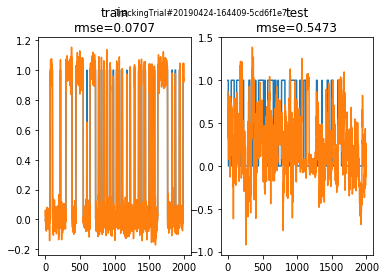

seed = 1
n_data = 50
dataset_dir = '../davis_io/data'
keep_invalid = True
task = 'valid'
dt = 0.1
decay_time = 1.0
n_neurons = 2000
gabor_size = 11
reg = 0.03
test_on_odd = False
rmse_test = 0.5472941753932022
rmse_train = 0.07070061861838746


{'rmse_train': 0.07070061861838746, 'rmse_test': 0.5472941753932022}

In [117]:
TrackingTrial().run(dt=0.1, n_data=50, plt=True, decay_time=1.0, test_on_odd=False, n_neurons=2000)